<a href="https://colab.research.google.com/github/anmolpandeybtech/lipWiz/blob/main/lipWiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [167]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [68]:
import gdown
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

SSLError: HTTPSConnectionPool(host='doc-0o-bg-docs.googleusercontent.com', port=443): Max retries exceeded with url: /docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hmt2dinkno814tiorid86qj72sflgqba/1708262925000/03817336214920875419/*/1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL?uuid=8e1c16d9-aee9-4002-9322-c7279e690b67 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1007)')))

In [168]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [169]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [170]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [171]:
char_to_num(['a', 'n', 'm', 'o', 'l'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 1, 14, 13, 15, 12])>

In [172]:
num_to_char([1, 14, 13, 15, 12]) #Byte encoded values show ho rahi h

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'a', b'n', b'm', b'o', b'l'], dtype=object)>

In [173]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [174]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [175]:
test_path = './data/s1/bbaf2n.mpg'    #/content/data/s1/bbaf2n.mpg

In [176]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [177]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [178]:
frames.shape

TensorShape([75, 46, 140, 1])

In [179]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

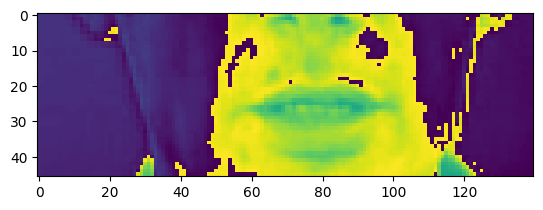

In [180]:
plt.imshow(frames[19])
plt.show()

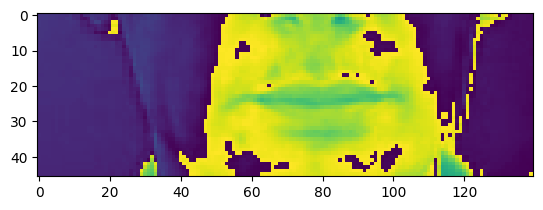

In [181]:
plt.imshow(frames[69])
plt.show()

In [182]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])  #Here space=39

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [183]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [184]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [185]:
len(test)

50

In [186]:
frames, alignments = data.as_numpy_iterator().next()

In [187]:
alignments

array([[19,  5, 20, 39, 19, 16, 39,  2, 12, 21,  5, 39, 23,  9, 20,  8,
        39,  2, 39, 20,  8, 18,  5,  5, 39, 19, 15, 15, 14,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39,  7, 39, 14,
         9, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [188]:
len(frames)

2

In [189]:
sample = data.as_numpy_iterator()

In [190]:
val = sample.next(); val[0]

array([[[[[1.4971485 ],
          [1.4971485 ],
          [1.45876   ],
          ...,
          [0.11516527],
          [0.11516527],
          [0.11516527]],

         [[1.4971485 ],
          [1.4971485 ],
          [1.45876   ],
          ...,
          [0.11516527],
          [0.11516527],
          [0.11516527]],

         [[1.4203717 ],
          [1.4203717 ],
          [1.4203717 ],
          ...,
          [0.07677685],
          [0.07677685],
          [0.07677685]],

         ...,

         [[0.99809897],
          [0.99809897],
          [0.95971054],
          ...,
          [9.635494  ],
          [9.635494  ],
          [9.635494  ]],

         [[0.99809897],
          [0.99809897],
          [0.95971054],
          ...,
          [9.597106  ],
          [9.597106  ],
          [9.597106  ]],

         [[0.99809897],
          [0.99809897],
          [0.95971054],
          ...,
          [9.597106  ],
          [9.597106  ],
          [9.597106  ]]],


        [[[1.3819

In [191]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

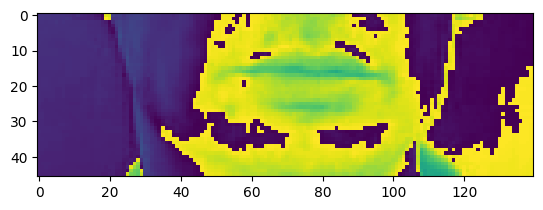

In [194]:
plt.imshow(val[0][0][69])

In [195]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green at q eight please'>